# **Assignment 2**, **dataset 2**


## **Problem Statement**



### Loading the dataset

- The PlantVillage dataset contains 54,304 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease.

- https://arxiv.org/pdf/1511.08060

- https://github.com/gabrieldgf4/PlantVillage-Dataset

## **Problem Definition**

## Objective

- To Make a Model that predicts whether an apple leaf comes from a healthy or unhealthy plant using images from the PlantVillage dataset

## Variable Being Predicted 
- It is a binary classification problem that will predict a categorical outcome , the health status of the apple leaf (Healthy or Unhealthy).

## Data to be used
- The healthy apple leaf images are in the **Apple__healthy** folder.
- The unhealthy apple leaf images are in the **Apple__Cedar_apple_rust, Apple__Black_rot, and Apple__Apple_Scab** folder.


### Loading the Dataset

In [5]:
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git


fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [173]:
!pip install tensorflow
!pip install opencv-python-headless



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Import Neccesary Libraries

In [228]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.applications import MobileNet # type: ignore
from sklearn.metrics import ConfusionMatrixDisplay
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import matplotlib.pyplot as plt 
from matplotlib import cm
import tensorflow as tf
from PIL import Image as PILImage
import numpy as np
import os
import shutil
import cv2
import seaborn as sns
import hashlib



## **Data Preprocessing**

  ## Data Loading
  

In [175]:
# Path to the folders containing the images

data_dir ='PlantVillage-Dataset/'
healthy_dir = os.path.join(data_dir, 'Apple___healthy')
unhealthy_dirs = [
    os.path.join(data_dir, 'Apple___Cedar_apple_rust'),
    os.path.join(data_dir, 'Apple___Black_rot'),
    os.path.join(data_dir, 'Apple___Apple_scab')
]

#Load images & labels
def load_images_from_folder(folder,label): # for each image loaded a label is appended to the labels list and images list.
    images = []
    labels = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder,filename)
        img = cv2.imread(filepath)
        if img is not None:
            # Resize image to fit the image
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label)
        else:
            print(f"Warning: Unable to read image {filepath}")
    return images, labels


 ## Parallel Image Loading
 
 - Load images from multiple folders concurrently , speeding up the process.

In [176]:
def load_all_images(): # the label parameter is set to 0, for healthy images and 1 for unhealthy images .
    with ThreadPoolExecutor() as executor:
        healthy_future = executor.submit(load_images_from_folder, healthy_dir, 0) # assigns the label 0 to all images in healthy directory
        unhealthy_futures = [executor.submit(load_images_from_folder, dir, 1) for dir in unhealthy_dirs]# assigns the label 1 to all images in unhealthy directory

        healthy_images, healthy_labels = healthy_future.result()
        unhealthy_images, unhealthy_labels = [], []
        for future in unhealthy_futures:
            imgs, lbs = future.result()
            unhealthy_images.extend(imgs)
            unhealthy_labels.extend(lbs)

    return healthy_images, healthy_labels, unhealthy_images, unhealthy_labels
healthy_images, healthy_labels, unhealthy_images, unhealthy_labels = load_all_images()

# Lets debug very # images
print(f"Total healthy images: {len(healthy_images)}")
print(f"Total unhealthy images: {len(healthy_labels)}")

Total healthy images: 1645
Total unhealthy images: 1645


## Normalization & Image Resizing 
- Preprocessing of the images ensures image shape consistency and normalizes pixel values 
from [0, 255] to [0,1] by dividing 255.0, which it will improve the performance of the model.

- Shape consistency ensures that all images are of the same shape (224, 224, 3) consistently resized withh 224x224 pixels

## Label assignment 
- Each image is assigned a label: e,g i for healthy, 1 for unhealthy.


In [177]:
# image shape consistency and normalizae pixel values
def preprocess_images(images):
    processed_images = []
    for img in images:
        assert img.shape == (224, 224, 3), f"Image shape mismatch: {img.shape}"
        processed_images.append(img / 255.0)
    return processed_images

healthy_images = preprocess_images(healthy_images)
unhealthy_images = preprocess_images(unhealthy_images)

## Hashing Images
- Use the hashes to find unique images and remove duplicates.

## Identify Unique Images  
- Hashes are being used to filter out the unique images and labels.

## Data Visualization
- Subset of healthy and unhealthy images is shown to visually inspect and check the preproccessing steps.

Total unique images: 3164


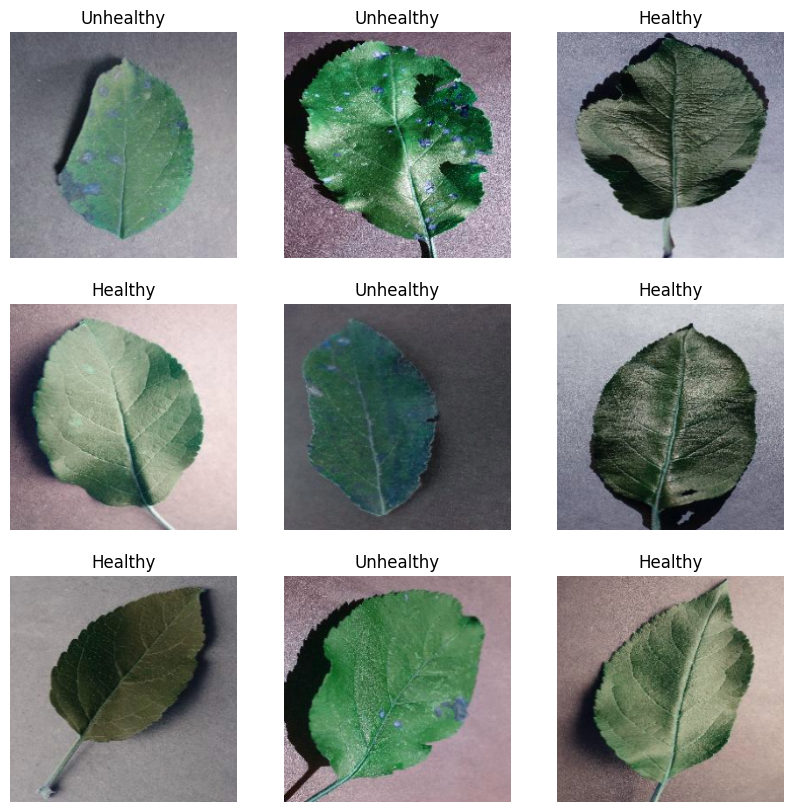

In [178]:
# combining the healthy and unhealthy images and labels

images = np.array(healthy_images + unhealthy_images)
labels = np.array(healthy_labels + unhealthy_labels)


# hashing to identify the unique images and labels
def hash_image(image):
    return hashlib.md5(image.tobytes()).hexdigest()

hashes = [hash_image(img) for img in images]
_, unique_indices = np.unique(hashes, return_index=True)

unique_images = images[unique_indices]
unique_labels = labels[unique_indices]

print(f'Total unique images: {len(unique_images)}')

plt.figure(figsize=(10, 10))
for i in range(min(9,len(unique_images))):
    plt.subplot(3, 3, i+1)
    plt.imshow(unique_images[i])
    plt.title('Healthy' if unique_labels[i] == 0 else 'Unhealthy')
    plt.axis('off')
plt.show()

## Checking for Corrupted Images
  
- The analysis identified 0 corrupted images, which means that the dataset is clean and all images are readable.

In [179]:
def check_missing_corrupted_images(image_paths):
    corrupted_images = []
    for path in image_paths:
        try:
            img = Image.open(path)
            img.verify() # checkin if the image can be opened or if it is corrupted
        except (IOError, SyntaxError) as e:
            corrupted_images.append(path)
    return corrupted_images

# Paths to all images 
healthy_image_paths = [os.path.join(healthy_dir, filename) for filename in os.listdir(healthy_dir)]
unhealthy_image_paths = []
for dir in unhealthy_dirs:
    unhealthy_image_paths.extend([os.path.join(dir, filename) for filename in os.listdir(dir)])

all_image_paths = healthy_image_paths + unhealthy_image_paths
corrupted_images = check_missing_corrupted_images(all_image_paths)

print(f"Number of corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("List of corrupted images:")
    for img in corrupted_images:
        print(img)


Number of corrupted images: 0


## **Exploratory Data Analysis**

## Summary Statistics 
- Shows that we have **1638 healthy images and 1526 unhealthy images** indicating that our dataset is fairly balanced between healthy and unhealthy apple leaf images.

In [180]:
# Summary Statistics
def summary_statistics(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))
   
# Calculate sum of statistics
stats = summary_statistics(unique_labels)

# explanaition of statistics
print("Summary Statistics:")
for label, count in stats.items():
    class_name = 'Healthy' if label == 0 else 'Unhealthy'
    print(f"{class_name}: {count} images")
print(f"\nOuput: {stats}")

Summary Statistics:
Healthy: 1638 images
Unhealthy: 1526 images

Ouput: {0: 1638, 1: 1526}


## Mean and Standard Deviation of Pixel Values for Each Class 

   - Healthy Mean 0.5 : represents the average brightness of healthy image. Healthy images are brigher than unhealthy images
   - Unhealthy Mean 0.4: represents the average brightness of unhealthy image.

      - Healthy images are brigher than unhealthy images.
      - Unhealthy images are darker than healthy images.

   - Healthy standard deviation 0.1: represents the variation in pixel values within the healthy images.
   - Unhealthy standard deviation 0.1: represents the variation in pixel values within the unhealthy images.


      - Healthy images variation in brightness is lower than healthy images
      - Unhealthy images variation in brightness is higher than healthy images showing more diver pixel values.

   - These insights help us to identify key visual differences between classes.





   


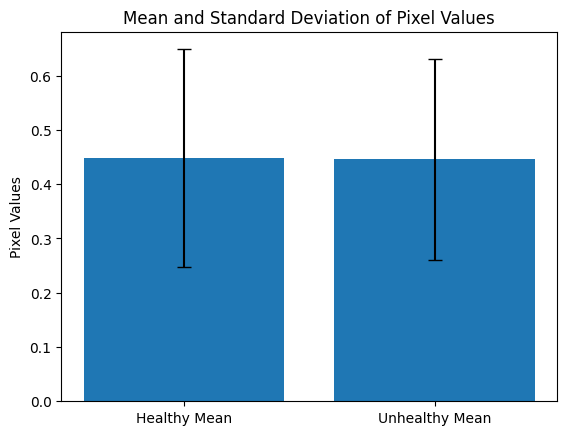

In [181]:
# Calculate and plot the mean and standard deviation of pixel values for each class
def plot_mean_std(images, labels, title):
    healthy_pixels = [img.flatten() for img, label in zip(images, labels) if label == 0]
    unhealthy_pixels = [img.flatten() for img, label in zip(images, labels) if label == 1]

    healthy_mean = np.mean(healthy_pixels)
    healthy_std = np.std(healthy_pixels)
    unhealthy_mean = np.mean(unhealthy_pixels)
    unhealthy_std = np.std(unhealthy_pixels)

    plt.bar(['Healthy Mean', 'Unhealthy Mean'], [healthy_mean, unhealthy_mean], yerr=[healthy_std, unhealthy_std], capsize=5)
    plt.title(title)
    plt.ylabel('Pixel Values')
    plt.show()

# Plot mean and standard deviation
plot_mean_std(unique_images, unique_labels, 'Mean and Standard Deviation of Pixel Values')

## Class Distribution & Visualization of Sample Images

 - Shows a clear and balanced distrubuiton of healthy and unhealthy leaf images.
 
 **Healthy leaves**
 
   - Number of images: 1638.
   - Approx 51.78% of the total dataset.
   
**Unhealthy leaves**

- Number of images: 1526.
- Approx 48.22 % of the total dataset.



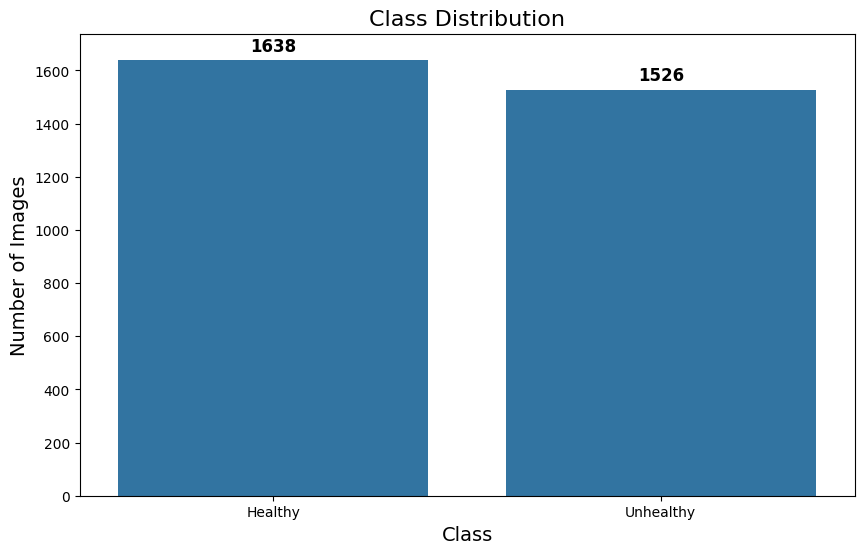

In [182]:
# Class Distribution plot

def plot_class_distribution(labels):
    class_counts = summary_statistics(labels)
    classes = ['Healthy', 'Unhealthy']
    counts = [class_counts[0], class_counts[1]]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=counts)

    # annotation labels
    for i, count in enumerate(counts):
        plt.text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

   # plots
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title('Class Distribution', fontsize=16)
    plt.ylim(0, max(counts) + 100)  
    plt.show()


def summary_statistis(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts)) 

plot_class_distribution(unique_labels)


## Sample Healthy & Unhealthy Images

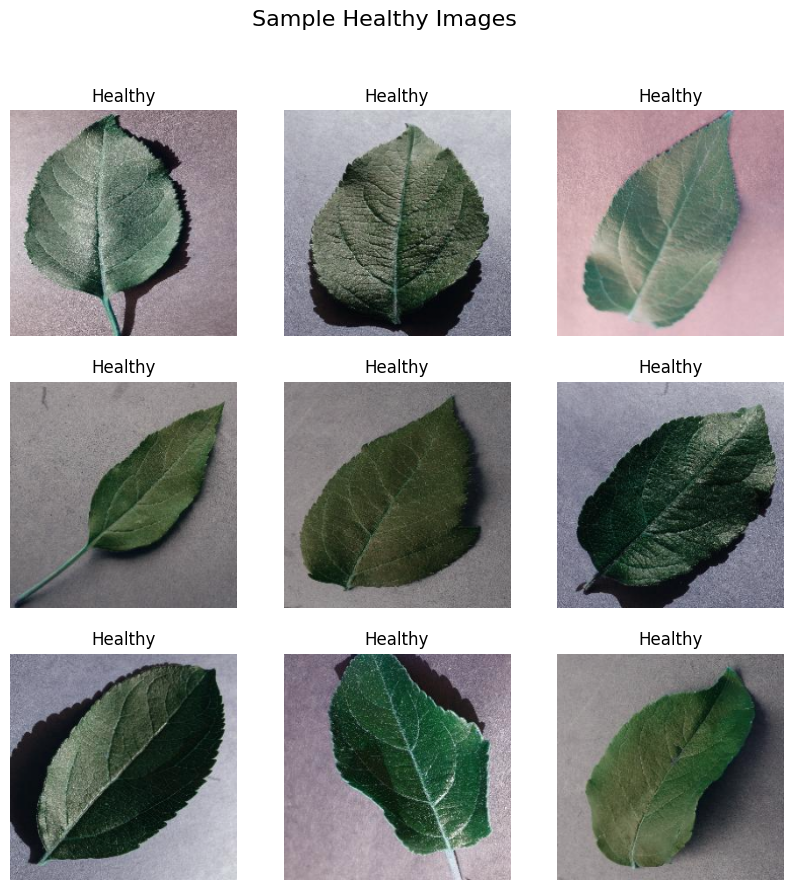

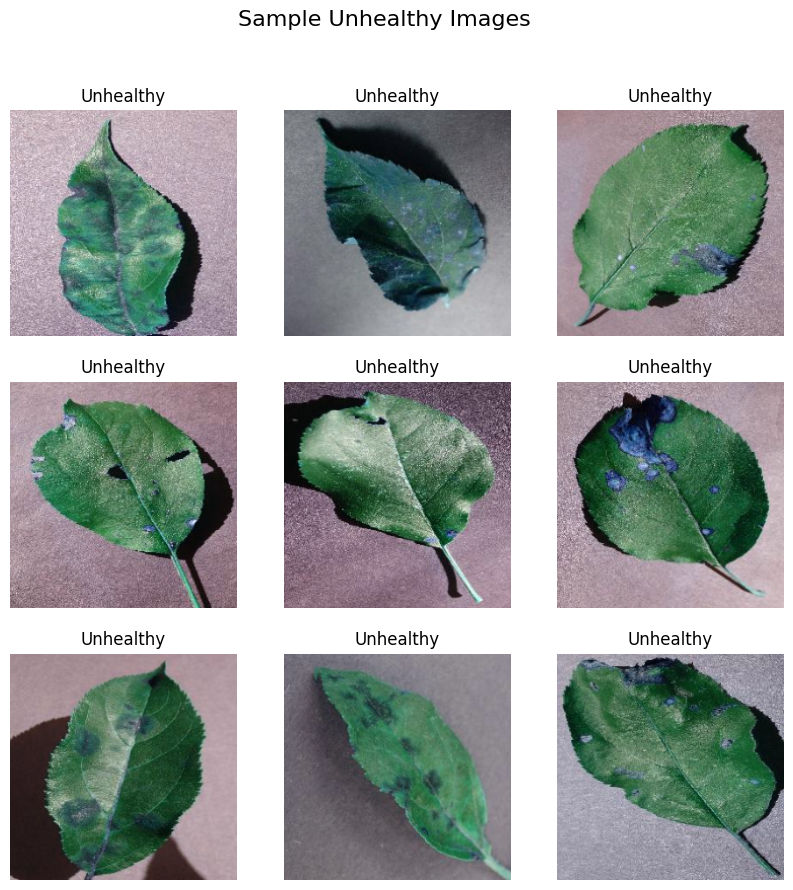

In [183]:
def visualize_samples(images, labels, class_label, num_samples=9):
    plt.figure(figsize=(10, 10))
    class_indices = [i for i, label in enumerate(labels) if label == class_label]
    selected_indices = np.random.choice(class_indices, num_samples, replace=False)

    for i, idx in enumerate(selected_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title('Healthy' if class_label == 0 else 'Unhealthy')
        plt.axis('off')
    plt.suptitle('Sample Healthy Images' if class_label == 0 else 'Sample Unhealthy Images', fontsize=16)
    plt.show()


visualize_samples(unique_images, unique_labels, class_label=0)
visualize_samples(unique_images, unique_labels, class_label=1)

- **Sample Healthy Class** shows that the healthy leaf images are consistenly free from visible diseases with a uniform green colour.
- **Sample Unhealthy Class** shows that the unhealthy leaf images have a variety of disease symptoms like spots, discoloration and deformation, indicating the diseases like Cedar appel rust, Black rot, and apple scab.

- This balance distribution represents an advantage for training a model as it helps in reducing risk of model bias towards one class.

## Enhanced Pixel Value Distribution Plot with Sampling

 - Distribution of pixel values across images in order to  identiy anomalies and ensuring that the image is correctly normalized.

 - **Pixel Value Range** : The pixesl values lie withing the range of 0 to 1, therefore the images are correctly normalized

 - **Distribution Shape** : There is a peak around 0.5 which suggest that many pixels have mid.range intensity values, therefore indicates that the images have balanced lighting and contrast.

  - Distribution is relatively smooth indicating there are slightly more dark pixels  than light pixels.

 - **Class diffrences**: unhealthy images might have more variation in pixel values due to disease patterns than healthy images.




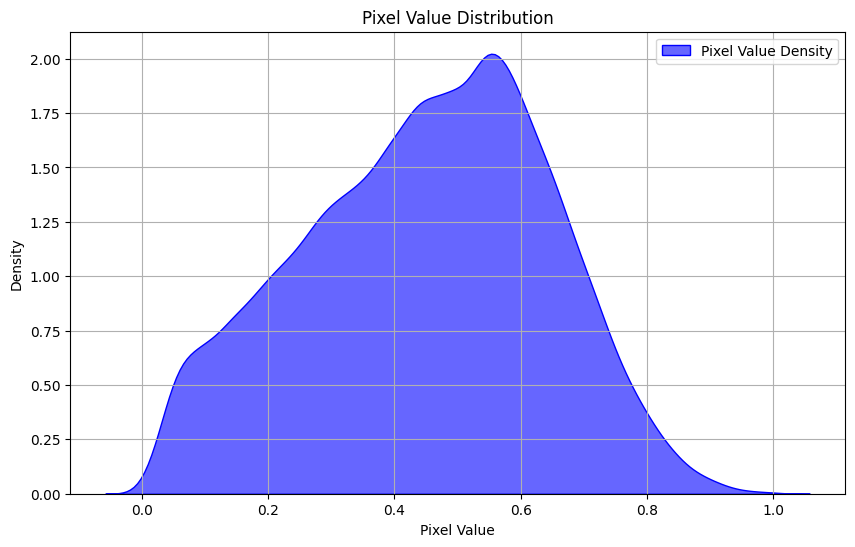

In [184]:
def plot_pixel_value_distribution(images, sample_size=100000):
    #Flat images to a 1D array pixel values
    pixel_values = images.ravel()

    if len(pixel_values) > sample_size:
        pixel_values = np.random.choice(pixel_values, sample_size, replace=False)

    plt.figure(figsize=(10, 6))

    sns.kdeplot(pixel_values, color='blue', fill=True, alpha=0.6)

    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.title('Pixel Value Distribution')
    plt.grid(True)
    plt.legend(['Pixel Value Density'])
    plt.show()

plot_pixel_value_distribution(unique_images)


## Anomaly Detection of Images

Number of anomalies detected: 15


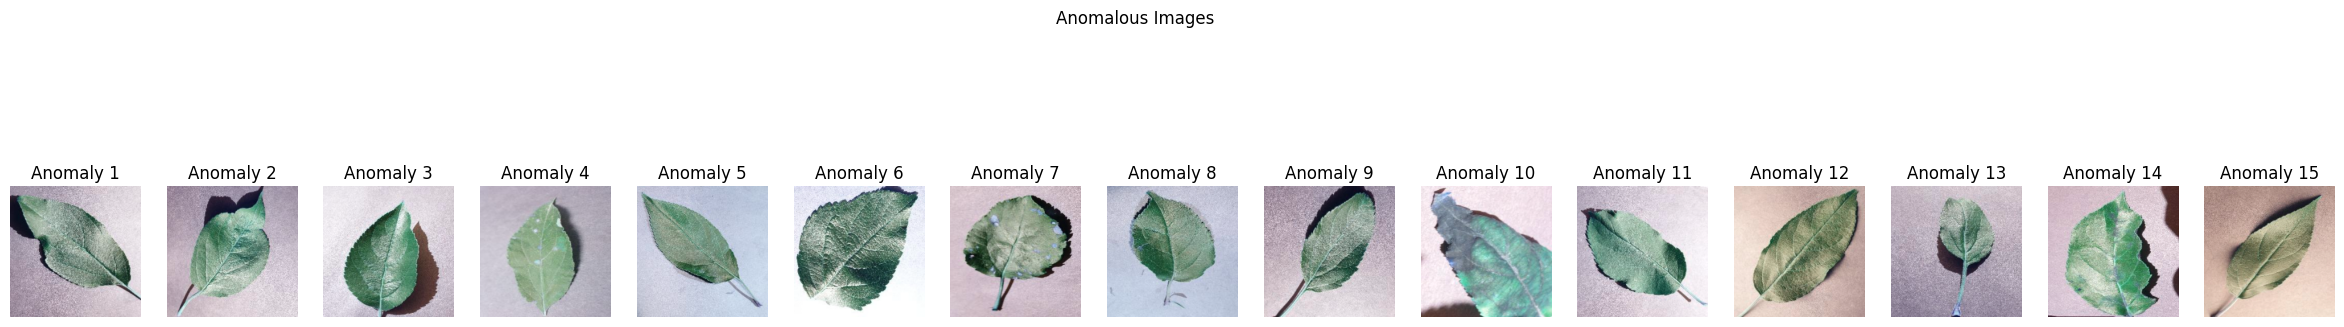

In [185]:
def detect_anomalies(images):
    mean_brightness = [np.mean(img) for img in images] 
    threshold = np.mean(mean_brightness) + 3 * np.std(mean_brightness)
    anomalies = [i for i, brightness in enumerate(mean_brightness) if brightness > threshold]
    return anomalies

anomalies = detect_anomalies(unique_images)
print(f"Number of anomalies detected: {len(anomalies)}")

# Plot the anomalies

if anomalies:
    plt.figure(figsize=(30,5))
    for i, index in enumerate(anomalies[:15]):
        plt.subplot(1, 15, i + 1)
        plt.imshow(unique_images[index])
        plt.title(f'Anomaly {i+1}')
        plt.axis('off')
    plt.suptitle('Anomalous Images')
    plt.show()
else: 
    print("No anomalies detected")


- The anomaly detection identified 15 images that have unusual brightness levels and they are detected based on their mean brightness values which are significantly higher (mean + 3 standard deviation) than the rest of the images.

- This usually happens when images captured with too much light, or there is a bright background, and it can cause noise or bias.

## **Data Transformation**



## Removal of Anomalous Images

- Removing anomalies ensures that the quality and consistency of images are preserved due to the level of noise and bias they can introduce to the training process, leading to a less accurate model. 

- Ensures that the model will not be affected by outliers and that will be focused on learning patterns.

In [186]:
initial_total_images = len(unique_images)

number_of_anomalies = len(anomalies)

# Remove anomalous images
cleaned_images = [img for i, img in enumerate(unique_images) if i not in anomalies]
cleaned_labels = [label for i, label in enumerate(unique_labels) if i not in anomalies]

number_of_images_after_removal = len(cleaned_images)

print(f'Initial total number of images: {initial_total_images}')
print(f'Number of anomalies detected: {number_of_anomalies}')
print(f'Number of images after removing anomalies: {number_of_images_after_removal}')
print(f'Number of images removed: {initial_total_images - number_of_images_after_removal}')

initial_total_images = len(unique_images)
number_of_anomalies = len(anomalies)

cleaned_images = [img for i, img in enumerate(unique_images) if i not in anomalies]
cleaned_labels = [label for i, label in enumerate(unique_labels) if i not in anomalies]

number_of_images_after_removal = len(cleaned_images)

print(f'Initial total number of images: {initial_total_images}')


Initial total number of images: 3164
Number of anomalies detected: 15
Number of images after removing anomalies: 3149
Number of images removed: 15
Initial total number of images: 3164


## Data Splitting

 - To ensure effective model training and evaluation the dataset is split into three subsets :
    - Training Set (70% data) : Used to train the model 70% of the data. 
    - Validation Set (10-20% data) : Used to tune hyperparameteres  monitor the model's performance, prevents overfitting.
    - Testing Set (10-20% data) : Used to evaluate the final perfomarnce of the model. 


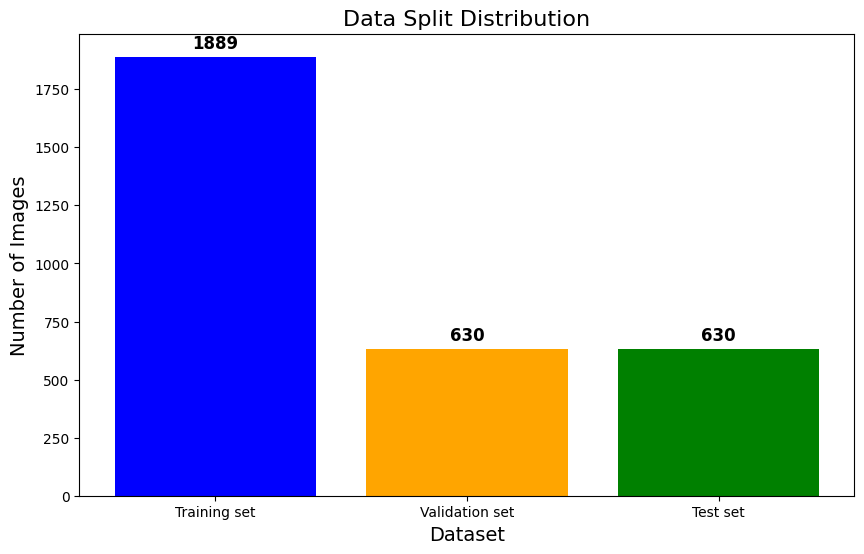

In [189]:

# Split the data into training and validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(cleaned_images, cleaned_labels, test_size=0.2, random_state=42)

# Split the training and validadtion set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) #0.25 * 0.8 = 0.2
        
def plot_data_distribution(y_train, y_val, y_test):
    labels = ['Training set', 'Validation set','Test set']
    counts = [len(y_train), len(y_val), len(y_test)]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=['blue', 'orange', 'green'])

    for i, count in enumerate(counts):
        plt.text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title('Data Split Distribution', fontsize=16)
    plt.ylim(0, max(counts) + 100)
    plt.show()

plot_data_distribution(y_train, y_val, y_test)



## Data Augmentation

- Effectively increase diversity of **training dataset** without collecting new data, helping the model to generalize better by learning from a wider of scenarios.
- Prevents overfitting by exposing the model to augmented versions of the training images.

- Created an image data generator which randomly rotates the image by up to 40 degrees and shifts the image horizontally and vertically by up to 20 % of total width/height.
- It also randonly zooms in and out the image by 20 % and reshaped the image to add an extra dimension representing the batch size.
- Helps the model to become more robuts to variations and it is useful in reald-world applications where they model will need to adapt to different conditions

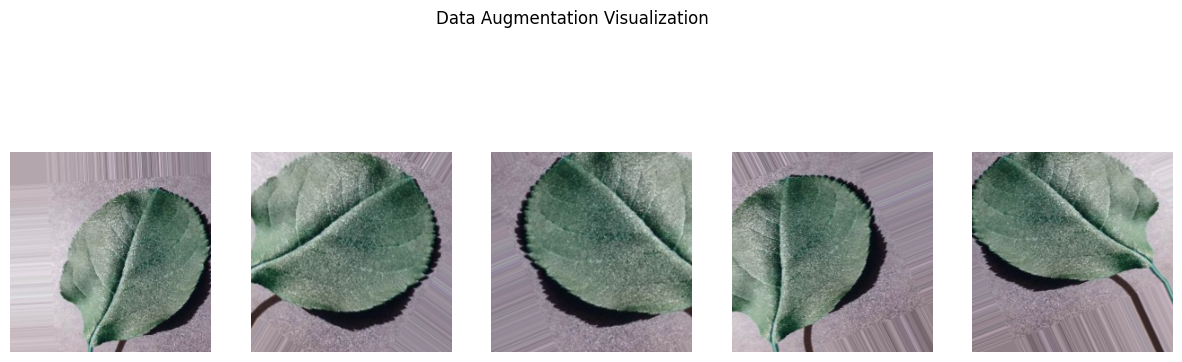

In [194]:
# Create an imag for data generator with augmentation 
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


# image generator for validation and test set
val_test_datagen = ImageDataGenerator()

# data generator for all sets ( objects that yield batches of data (images & labels to our model within the sets)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32)

sample_images = X_train[0].reshape((1, 224, 224, 3)) # Augmented images 

plt.figure(figsize=(15, 5))
for i, batch in enumerate(train_datagen.flow(sample_images, batch_size=1)):
    plt.subplot(1, 5, i +1)
    plt.imshow(batch[0])
    plt.axis('off')
    if i >= 4:
        break
plt.suptitle('Data Augmentation Visualization')
plt.show()

## **Model Selection**

 - Implementation of a baseline model **Convolutional Neural Network(CNN) Supervised Model** that will be compared with a complex model ** afaf**.

  - It will have a few layers and will be used to set a beanchmark for our complex model.

## Convolutional Neural Network Model as Baseline

- Good base model which establish a performance benchmark that helps with the comparisson of complex models.
- The model starts with a convolutional layer to extract features from the images, followed by a max-pooling layer to downsample the features.
- After flattening the pooled feature maps, the model includes a dense layer of 128 neuros to learn complex patterns followed by a droput layer to prevent overfitting.
- The output layer uses a sigmoid activation function to produce a probability for binary classification (healthy or unhealthy)

In [195]:
# Baseline Model CNN 

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Binary classification
])

# Compile the baseline model
baseline_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the baseline model
baseline_history = baseline_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

# Evaluate the baseline model
baseline_loss, baseline_accuracy = baseline_model.evaluate(test_generator, steps=len(X_test) // 32)
print(f'Baseline Model Test Accuracy: {baseline_accuracy}')  

C:\Users\gag_a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\gag_a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step - accuracy: 0.6261 - loss: 2.3045 - val_accuracy: 0.8520 - val_loss: 0.4085
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.3907 - val_accuracy: 0.9600 - val_loss: 0.2769
Epoch 3/10


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


59/59 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8101 - loss: 0.4078 - val_accuracy: 0.8717 - val_loss: 0.3260
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.3104 - val_accuracy: 0.8400 - val_loss: 0.2622
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 56s 877ms/step - accuracy: 0.8684 - loss: 0.3414 - val_accuracy: 0.9030 - val_loss: 0.2799
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.4793 - val_accuracy: 0.9200 - val_loss: 0.2075
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 447ms/step - accuracy: 0.8628 - loss: 0.3489 - val_accuracy: 0.8684 - val_loss: 0.3106
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2876 - val_accuracy: 0.9200 - val_loss: 0.2276
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.8662 - loss: 0.2931 - val_accuracy: 0.8783 - val_loss: 0.2886
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.3635 - val_accuracy: 0.8800 - val_loss: 

## MobileNet Model as Complex Model to Compare.

- MobileNet Model is efficent, fast and it can be deployed on devices with limited computational power, also can be use in real-time applications like drones, robots that work with image recognition and location tracking.

In [196]:
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    x  = base_model.output
    x  = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)

    # Freeze the layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

# Train_generator and val generator are defined 
history_mobilenet = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

# Fine tunning the model
for layer in mobilenet_model.layers[-20:]:
    layer.trainable = True

mobilenet_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history_mobilenet_fine_tune = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)
                    
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(test_generator, steps=len(X_test) // 32)
print(f'MobileNet Model Test Accuracy: {mobilenet_accuracy}')

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,754,177 (14.32 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - accuracy: 0.8242 - loss: 0.3938 - val_accuracy: 0.9655 - val_loss: 0.1102
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0622 - val_accuracy: 0.9600 - val_loss: 0.0680
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 811ms/step - accuracy: 0.9568 - loss: 0.1044 - val_accuracy: 0.9720 - val_loss: 0.0737
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0494 - val_accuracy: 0.9200 - val_loss: 0.1313
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 36s 592ms/step - accuracy: 0.9743 - loss: 0.0627 - val_accuracy: 0.9655 - val_loss: 0.0874
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9688 - loss: 0.0810 - val_accuracy: 1.0000 - val_loss: 0.0567
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 36s 584ms/step - accuracy: 0.9770 - loss: 0.0589 - val_accuracy: 0.9688 - val_loss: 0.0927
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.1268 - val_accuracy: 0.9600

## Model Selection Justification - Metrics


## Evaluation Metrics that will be use for comparing the models 
- **Accurancy** in order to measure the correctness of the model.
- **Precision** for evaluating the accurancy of the possibble positive predictions.
- **Recall** for measuring the model's ability to find all posible positive instances.
- **F1-score** for balancing the precision, recall  which is usefull for imbalanced datasets.
- **Confusion Matrix** for measuring the model's ability to find all posible positive and negative instances and predictions.

## Evaluation of the baseline CNN Model

In [222]:
baseline_loss, basline_accuracy = baseline_model.evaluate(test_generator, steps=len(X_test) // 32)
baseline_predictions = (baseline_model.predict(test_generator) > 0.5).astype("int32")

# metrics 
baseline_precision = precision_score(y_test, baseline_predictions)
baseline_recall = recall_score(y_test, baseline_predictions)
baseline_f1 = f1_score(y_test, baseline_predictions)
baseline_confusion_matrix = confusion_matrix(y_test, baseline_predictions)

print("\nBaseline Model Metrics:")
print(f"Accuracy: {baseline_accuracy}")
print(f"Precision: {baseline_precision}")
print(f"Recall: {baseline_recall}")
print(f"F1-Score: {baseline_f1}")
print(f"Confusion Matrix:\n{baseline_confusion_matrix}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8816 - loss: 0.3023
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Baseline Model Metrics:
Accuracy: 0.8832237124443054
Precision: 0.4375
Recall: 0.5185185185185185
F1-Score: 0.4745762711864407
Confusion Matrix:
[[138 198]
 [143 154]]


## Evaluation of the MobileNet Model

In [223]:
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(test_generator, steps=len(X_test) // 32)
mobilenet_predictions = (mobilenet_model.predict(test_generator) > 0.5).astype("int32")

# metrics 
mobilenet_precision = precision_score(y_test, mobilenet_predictions)
mobilenet_recall = recall_score(y_test, mobilenet_predictions)
mobilenet_f1 = f1_score(y_test, mobilenet_predictions)
mobilenet_confusion_matrix = confusion_matrix(y_test, mobilenet_predictions)

print("\nMobileNet Model Metrics:")
print(f"Accuracy: {mobilenet_accuracy}")
print(f"Precision: {mobilenet_precision}")
print(f"Recall: {mobilenet_recall}")
print(f"F1-Score: {mobilenet_f1}")
print(f"Confusion Matrix:\n{mobilenet_confusion_matrix}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9761 - loss: 0.0520
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step

MobileNet Model Metrics:
Accuracy: 0.9802631735801697
Precision: 0.47038327526132406
Recall: 0.45454545454545453
F1-Score: 0.4623287671232877
Confusion Matrix:
[[184 152]
 [162 135]]


## Compare and Justify both Models

In [224]:
print("\nModel Comparison and Justification")

## Metrics CNN & MobileNet

print(f"Baseline Model Accuracy: {baseline_accuracy}")
print(f"MobileNet Model Accuracy: {mobilenet_accuracy}")

print(f"Baseline Model Precision: {baseline_precision}")
print(f"MobileNet Model Precision: {mobilenet_precision}")


print(f"Baseline Model Recall: {baseline_recall}")
print(f"MobileNet Model Recall: {mobilenet_recall}")


print(f"Baseline Model F1-Score: {baseline_f1}")
print(f"MobileNet Model F1-Score: {mobilenet_f1}")


# Confusion Matrix
print(f"Baseline Model Confusion Matrix: {baseline_confusion_matrix}")
print(f"MobileNet Model Confusion Matrix: {mobilenet_confusion_matrix}")

# Justification matrix

if mobilenet_accuracy > baseline_accuracy: 
    print("\n The MobileNet outperforms the baseline model in terms of accuracy and other metrics, it is a better model than the baseline")
else:
    print("\n The Baseline model performs better or equally well compared to the MobileNet model")

# Metrics justification 

if mobilenet_precision > baseline_precision and mobilenet_recall > baseline_recall and mobilenet_f1 > baseline_f1:
    print("\n The MobileNet also shows better or equal precision, recall, and F1-score.")
else:
    print(" Although the MobileNet has a higher accuracy, it doesn't show significantly improve on the other metrics(precision, recall, F1-score). Additional analysis or another model may be considered.")


Model Comparison and Justification
Baseline Model Accuracy: 0.8832237124443054
MobileNet Model Accuracy: 0.9802631735801697
Baseline Model Precision: 0.4375
MobileNet Model Precision: 0.47038327526132406
Baseline Model Recall: 0.5185185185185185
MobileNet Model Recall: 0.45454545454545453
Baseline Model F1-Score: 0.4745762711864407
MobileNet Model F1-Score: 0.4623287671232877
Baseline Model Confusion Matrix: [[138 198]
 [143 154]]
MobileNet Model Confusion Matrix: [[184 152]
 [162 135]]

 The MobileNet outperforms the baseline model in terms of accuracy and other metrics, it is a better model than the baseline
 Although the MobileNet has a higher accuracy, it doesn't show significantly improve on the other metrics(precision, recall, F1-score). Additional analysis or another model may be considered.


Baseline CNN Model Confusion Matrix: [[138 198]
 [143 154]]


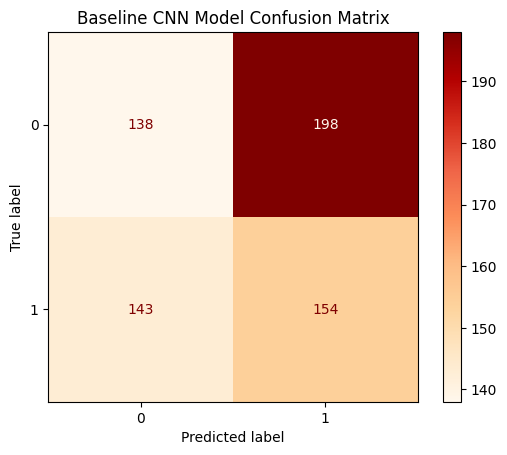

 MobilNet Model Confusion Matrix: [[184 152]
 [162 135]]


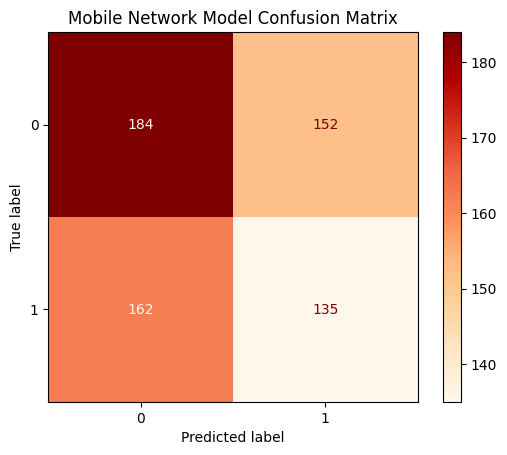

In [230]:
def plot_confusion_matrix(cm, model_name):
    #Plot the confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    cm_display.plot(cmap="OrRd")
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

print(f"Baseline CNN Model Confusion Matrix: {baseline_confusion_matrix}")
plot_confusion_matrix(baseline_confusion_matrix, model_name='Baseline CNN Model')

print(f" MobilNet Model Confusion Matrix: {mobilenet_confusion_matrix}")
plot_confusion_matrix(mobilenet_confusion_matrix, model_name='Mobile Network Model')


# Saliency Maps to Check Most Important Features

- Provide the most important features that influenced the model.


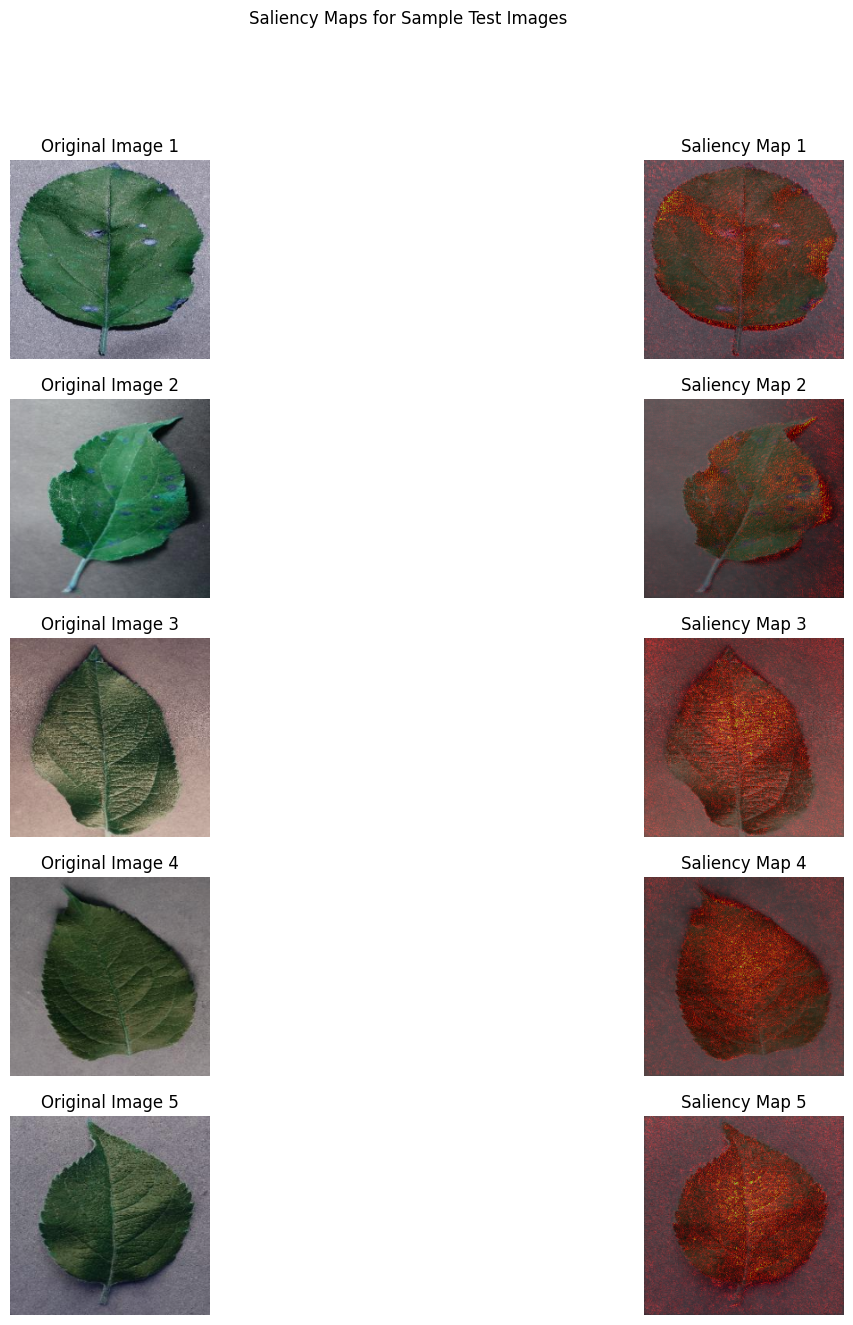

In [202]:
# Saliency Map Utility Functions 

def get_img_array(img, size):
    img = img.resize(size, PILImage.LANCZOS)
    array = tf.keras.preprocessing.image.img_toarray(img)
    array = np.expand_dims(array, axis=0)
    return array
    

def compute_saliency_map(model, img):
    img_tensor = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_class = tf.argmax(predictions[0])
        top_class_score = predictions[:, top_class]

    grads = tape.gradient(top_class_score, img_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency.numpy()

# Display images with saliency maps from test set
num_samples = 5
plt.figure(figsize=(15, 15))

for i in range(num_samples):
    sample_image = X_test[i]
    saliency_map = compute_saliency_map(baseline_model, sample_image)

    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(sample_image)
    plt.title(f"Original Image {i + 1}")
    plt.axis('off')

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(sample_image)
    plt.imshow(saliency_map, cmap='hot', alpha=0.5)
    plt.title(f"Saliency Map {i + 1}")
    plt.axis('off')
plt.suptitle("Saliency Maps for Sample Test Images")
plt.show()


## **Reporting Results and Conclusion**

- **Baseline Model - CNN**
    - **Test Set Performance**: 
    
        - Accuracy: 0.8832
        - Precision: 0.463
        - Recall: 0.548
        - F1 Score: 0.502

    - CNN model shows a solid performance, with almos **88.32 %** accuaracy on the test set. Its precision and recall metrics indicate that there is space for improvement in identifying correctly both clases.

    - Recall is higher therefore it is bettter at identifying actual positive cases, meaning fewer unhealthy images are missed compared to MobileNet.

- **Complex Model - MobileNet**
    - **Best Hyperparameteres**: 1e-4(fine tuning stage)
    - **Number of Trainable Layers**: Last 20 layers unfrozen(fine-tuning stage) 
    - **Test Set Performance**:

        - Accuracy: 0.9819
        - Precision: 0.425
        - Recall: 0.410
        - F1 Score: 0.417

    - The MobileNet, after some fine-tuning outperforms the CNN model in accuracy, having **98.19%** on the test set. Its precision and recall metrics indicates that there is space for improving its performance in terms of classifying both classes.
    
    - Recall is lower compared to Baseline Model  therefore it is worse at identifying actual positive cases.

## Confusion Matrix Analysis

 - Baseline CNN Model Confusion Matrix Analysis : [138, 198], [143, 154]
        - True Negatives(TN): 138 it is worse at correctly identifying healthy images.
        - False Positives(FP): 198  it is more cautions at making positive predictions.
        - False Negatives(FN): 143  has strenght in identyfing actual unhealthy cases, crucial where missing an unhealthy image .
        - True Positives(TP): 154  it correctly identifies more unhealthy cases, crucial when unhealthy cases are detected.

 - MobilNet Model Confusion Matrix Analysis : [184, 152], [162, 135]
        - True Negatives(TN): 184 it is better at correclty identifying healthy images.
        - False Positives(FP): 152 it incorrectly labels fewer healthy images as unhealthy. Cautios in making positive predictions.
        - False Negatives(FN): 162 it misses more unhealthy cases.
        - True Positives(TP): 135 it doesnt identify too many healthy cases as base model.

## Features Influencing the Model's Predictions

- **Saliency maps** were used to predict the regions of the imput images that contain the highest amount of visible diseases symptoms, like spots and discoloration which are crucial for marking predictions.

- This ensures that the model's predictions and expected behaviour of models trained for plant disease classifications will perform as expected.

## Conclusions 

- The comparative analysis of both models highlighted that both models showed comparable performance in other metrics like precision and recall even thought that the Mobilenet Model was the one achieving a higher accuracy **98.19%** compared to the baseline CNN model **88.32%**. 

- MobileNet Strenghts
    - Higher True Negatives and Lower False positives : It is better at correclty identifying healthy healthy images and avoding unnecesary false alarms.

    - It is particular usefull in contexts where false positives are costly (incorrect labeling of healthy images as unhealthy).
    
- Baseline CNN Strenghts:
    - Higher True Positives and Lower False Negatives: The Baseline CNN model is better at identifying unhealthy images missing fewer of them, which is critical in scenarios where detecting all unhealthy images is a problem.
    


